# 01 - Exploratory Data Analysis, Data Scraping, and Preprocessing Prototype

This notebook provides a foundational prototype for collecting, cleaning, and analyzing Amharic e-commerce messages. We will systematically cover the following stages:

1.  **Data Ingestion:** Programmatically collect raw message data (text, images, and associated metadata) from specified Telegram channels.
2.  **Data Preprocessing:** Apply a custom, modular pipeline to clean, normalize, and prepare the raw Amharic text for further analysis.
3.  **Exploratory Data Analysis (EDA):** Conduct a detailed analysis of the collected and preprocessed data to understand its characteristics, identify patterns, and assess data quality.

## 1. Setup and Imports

First, we'll set up our environment by importing necessary libraries and ensuring our `src` directory is in the Python path so we can import our custom modules.

In [1]:
import os
import sys
import pandas as pd
import asyncio
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter
import re
from pathlib import Path


# Set plot style
sns.set_style('whitegrid')

# Add the project root to sys.path to enable absolute imports from 'src'
import sys
project_root = Path.cwd() # Navigates from 'notebooks/' directory to the project root
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# Import custom modules
from src.data_ingestion.telegram_scraper import main as run_scraper_main
from src.data_preprocessing.text_preprocessor import preprocess_dataframe, preprocess_amharic_text, AMHARIC_STOP_WORDS

# Define paths relative to the project root
DATA_DIR = os.path.join(project_root, 'data')
RAW_DATA_DIR = os.path.join(DATA_DIR, 'raw')
PROCESSED_DATA_DIR = os.path.join(DATA_DIR, 'processed')
CONFIG_DIR = os.path.join(project_root, 'config')

RAW_CSV_PATH = os.path.join(RAW_DATA_DIR, 'telegram_data.csv')
PROCESSED_CSV_PATH = os.path.join(PROCESSED_DATA_DIR, 'preprocessed_telegram_data.csv')
CHANNELS_LIST_PATH = os.path.join(CONFIG_DIR, 'channels_to_crawl.csv')

# Ensure output directories exist
os.makedirs(RAW_DATA_DIR, exist_ok=True)
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

print("Setup complete. Paths defined and directories ensured.")

Setup complete. Paths defined and directories ensured.


## 2. Data Ingestion (Scraping Prototype)

This section demonstrates the process of ingesting raw message data from Telegram channels using our custom scraper. The scraper is designed to append new data to `telegram_data.csv` on each run, allowing for continuous data collection. It also handles downloading associated media files.

**Before running:**
1.  Ensure your Telegram API credentials (`TELEGRAM_API_ID`, `TELEGRAM_API_HASH`) are correctly set in a `.env` file located in your **project root** directory.
2.  Verify that `config/channels_to_crawl.csv` is populated with the Telegram channel usernames you intend to scrape (e.g., `Shageronlinestore`, `EthiopianMarketPlace`, etc.).

In [2]:
print(f"Checking for channels list at: {CHANNELS_LIST_PATH}")
if not os.path.exists(CHANNELS_LIST_PATH):
    print(f"Warning: '{CHANNELS_LIST_PATH}' not found. Creating a placeholder.")
    with open(CHANNELS_LIST_PATH, 'w', newline='', encoding='utf-8') as f:
        f.write('channel_username\n')
        f.write('Shageronlinestore\n') # Example channel, please add more
    print(f"Created a placeholder '{CHANNELS_LIST_PATH}'. **Please edit it with your target channels.**")


# Set a limit for demonstration purposes. Remove `message_limit` or set to `None` to scrape all.
# This is especially useful for first runs to quickly see results.
scrape_limit = 50 # Scrape up to 50 messages per channel for prototyping

print(f"Starting Telegram data ingestion (limit={scrape_limit} messages per channel)...")
try:
    # To run an asynchronous function like `run_scraper_main` in a Jupyter/IPython environment,
    # `asyncio.run()` is used. If you encounter a `RuntimeError: This event loop is already running`,
    # it means Jupyter's event loop is already active. In such cases, you might need to:
    # 1. Restart your Jupyter kernel (most common fix).
    # 2. Use `!pip install nest_asyncio` and then `import nest_asyncio; nest_asyncio.apply()` at the top of your notebook.
    # For simplicity, we stick to `asyncio.run()` with the assumption of a fresh kernel state.
    asyncio.run(run_scraper_main(message_limit=scrape_limit))
    print("Telegram data ingestion complete.")
except Exception as e:
    print(f"\nError during scraping: {e}")
    print("Please ensure your .env file is correctly set up with TELEGRAM_API_ID and TELEGRAM_API_HASH.")
    print("Also, verify that the channels in channels_to_crawl.csv are valid and public.")
    print("If 'RuntimeError: This event loop is already running' persists, restart the kernel or consider 'nest_asyncio'.")


# Load the raw data after scraping
raw_df = pd.DataFrame() # Initialize empty DataFrame
if os.path.exists(RAW_CSV_PATH):
    try:
        raw_df = pd.read_csv(RAW_CSV_PATH, encoding='utf-8')
        print(f"\nLoaded raw data: {raw_df.shape[0]} messages.")
        print("Raw Data Sample:")
        display(raw_df.head())
        print("Raw Data Info:")
        raw_df.info()
    except pd.errors.EmptyDataError:
        print(f"Warning: Raw CSV '{RAW_CSV_PATH}' is empty. No data was scraped.")
    except Exception as e:
        print(f"Error loading raw CSV: {e}")
else:
    print(f"Raw data CSV not found at '{RAW_CSV_PATH}'. Please ensure the scraping cell runs successfully.")

Checking for channels list at: /home/micha/Downloads/course/10-accademy/week-4/amharic-ecommerce-data-extractor/config/channels_to_crawl.csv
Starting Telegram data ingestion (limit=50 messages per channel)...

Error during scraping: asyncio.run() cannot be called from a running event loop
Please ensure your .env file is correctly set up with TELEGRAM_API_ID and TELEGRAM_API_HASH.
Also, verify that the channels in channels_to_crawl.csv are valid and public.
If 'RuntimeError: This event loop is already running' persists, restart the kernel or consider 'nest_asyncio'.

Loaded raw data: 336 messages.
Raw Data Sample:


/tmp/ipykernel_61597/769348021.py:28: RuntimeWarning: coroutine 'main' was never awaited
  print("If 'RuntimeError: This event loop is already running' persists, restart the kernel or consider 'nest_asyncio'.")


,channel_title,channel_username,message_id,message_text,message_date,sender_id,sender_username,media_path,media_type,views
0,NEVA COMPUTER®,@nevacomputer,8779,💻 Dell Precision Workstation\n\nA powerful per...,2025-06-21T06:32:27+00:00,-1001195361398,nevacomputer,media/@nevacomputer_8779_photo.jpg,photo,460
1,NEVA COMPUTER®,@nevacomputer,8778,NaN,2025-06-21T06:32:27+00:00,-1001195361398,nevacomputer,media/@nevacomputer_8778_photo.jpg,photo,458
2,NEVA COMPUTER®,@nevacomputer,8777,NaN,2025-06-21T06:32:27+00:00,-1001195361398,nevacomputer,media/@nevacomputer_8777_photo.jpg,photo,458
3,NEVA COMPUTER®,@nevacomputer,8776,NaN,2025-06-21T06:32:27+00:00,-1001195361398,nevacomputer,media/@nevacomputer_8776_photo.jpg,photo,393
4,NEVA COMPUTER®,@nevacomputer,8775,NaN,2025-06-11T13:56:52+00:00,-1001195361398,nevacomputer,media/@nevacomputer_8775_photo.jpg,photo,1486


Raw Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   channel_title     336 non-null    object
 1   channel_username  336 non-null    object
 2   message_id        336 non-null    object
 3   message_text      178 non-null    object
 4   message_date      336 non-null    object
 5   sender_id         336 non-null    object
 6   sender_username   336 non-null    object
 7   media_path        333 non-null    object
 8   media_type        333 non-null    object
 9   views             335 non-null    object
dtypes: object(10)
memory usage: 26.4+ KB


## 3. Data Preprocessing

This section applies a series of modular and Amharic-specific preprocessing steps to the raw text data. These steps, defined in `src/data_preprocessing/text_processor.py`, aim to clean, normalize, and standardize the text, making it suitable for subsequent NLP tasks like Named Entity Recognition.

In [3]:
processed_df = pd.DataFrame() # Initialize empty DataFrame

if not raw_df.empty:
    print("Applying preprocessing to raw data...")
    # Note: For Named Entity Recognition, it's generally recommended *not* to remove stopwords
    # as they can provide crucial contextual information for entity boundaries. Hence, remove_stopwords=False.
    processed_df = preprocess_dataframe(raw_df.copy(), remove_stopwords=False)
    
    print(f"\nPreprocessed data: {processed_df.shape[0]} messages.")
    print("Preprocessed Data Sample (showing original vs. preprocessed text):")
    display(processed_df[['message_text', 'preprocessed_text']].head())

    # Save the preprocessed data
    processed_df.to_csv(PROCESSED_CSV_PATH, index=False, encoding='utf-8')
    print(f"Preprocessed data saved to {PROCESSED_CSV_PATH}")
else:
    print("No raw data loaded or DataFrame is empty. Attempting to load existing preprocessed data for EDA.")
    if os.path.exists(PROCESSED_CSV_PATH):
        try:
            processed_df = pd.read_csv(PROCESSED_CSV_PATH, encoding='utf-8')
            print(f"Loaded existing preprocessed data: {processed_df.shape[0]} messages.")
            display(processed_df.head())
        except pd.errors.EmptyDataError:
            print(f"Warning: Processed CSV '{PROCESSED_CSV_PATH}' is empty.")
        except Exception as e:
            print(f"Error loading processed CSV: {e}")
    else:
        print("No preprocessed data found. Please ensure data ingestion and preprocessing runs successfully.")

2025-06-21 22:39:47,983 - INFO - Starting text preprocessing on column 'message_text'...


Applying preprocessing to raw data...


2025-06-21 22:39:48,660 - INFO - Text preprocessing complete.



Preprocessed data: 336 messages.
Preprocessed Data Sample (showing original vs. preprocessed text):


,message_text,preprocessed_text
0,💻 Dell Precision Workstation\n\nA powerful per...,Dell Precision Workstation A powerful performa...
1,,
2,,
3,,
4,,


Preprocessed data saved to /home/micha/Downloads/course/10-accademy/week-4/amharic-ecommerce-data-extractor/data/processed/preprocessed_telegram_data.csv


## 4. Exploratory Data Analysis (EDA) on Processed Data

This section delves into a detailed exploratory data analysis of the collected and preprocessed Telegram messages. The insights gained here are crucial for understanding the dataset's characteristics, informing subsequent machine learning model development, and deriving actionable business intelligence.

### 4.1 Dataset Overview and Data Quality

#### 4.1.1 Dataset Summary

In [4]:
if 'processed_df' in locals() and not processed_df.empty:
    print("### Dataset Overview ###")
    print(f"Total messages: {processed_df.shape[0]}")
    print(f"Number of columns: {processed_df.shape[1]}")
    print("\nDataFrame Info:")
    processed_df.info()

### Dataset Overview ###
Total messages: 336
Number of columns: 11

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   channel_title      336 non-null    object
 1   channel_username   336 non-null    object
 2   message_id         336 non-null    object
 3   message_text       336 non-null    object
 4   message_date       336 non-null    object
 5   sender_id          336 non-null    object
 6   sender_username    336 non-null    object
 7   media_path         333 non-null    object
 8   media_type         333 non-null    object
 9   views              335 non-null    object
 10  preprocessed_text  336 non-null    object
dtypes: object(11)
memory usage: 29.0+ KB


#### 4.1.2 Data Completeness (Missing Values)

In [5]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Missing Values Analysis ###")
    missing_values = processed_df.isnull().sum()
    missing_percent = (processed_df.isnull().sum() / len(processed_df)) * 100
    missing_df = pd.DataFrame({'Missing Count': missing_values, 'Missing %': missing_percent})
    print(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False))

    # Convert 'views' to numeric (coerce errors to NaN) ---
    if 'views' in processed_df.columns:
        processed_df['views'] = pd.to_numeric(processed_df['views'], errors='coerce')
        print("\n'views' column converted to numeric type, non-numeric values coerced to NaN.")

    print("\nInterpretation: The dataset currently contains 336 messages. We observe minimal missing data; 'media_path' and 'media_type' have 0.89% missing values, which is expected for messages without attached media. The 'views' column is highly complete (0.29% missing) and has been successfully converted to a numeric type, ensuring its usability for quantitative analysis. Critically, the 'message_text' and 'preprocessed_text' columns are fully populated, confirming the reliability of our core textual data.")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")


### Missing Values Analysis ###
            Missing Count  Missing %
media_path              3   0.892857
media_type              3   0.892857
views                   1   0.297619

'views' column converted to numeric type, non-numeric values coerced to NaN.

Interpretation: The dataset currently contains 336 messages. We observe minimal missing data; 'media_path' and 'media_type' have 0.89% missing values, which is expected for messages without attached media. The 'views' column is highly complete (0.29% missing) and has been successfully converted to a numeric type, ensuring its usability for quantitative analysis. Critically, the 'message_text' and 'preprocessed_text' columns are fully populated, confirming the reliability of our core textual data.


### 4.2 Channel and Engagement Analysis

#### 4.2.1 Message Distribution Across Channels


### Message Distribution Across Channels ###
Number of unique channels scraped: 21


/tmp/ipykernel_61597/837377578.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=channel_counts.values, y=channel_counts.index, palette='viridis')
/tmp/ipykernel_61597/837377578.py:12: UserWarning: Glyph 4632 (\N{ETHIOPIC SYLLABLE MA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/837377578.py:12: UserWarning: Glyph 4752 (\N{ETHIOPIC SYLLABLE NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/837377578.py:12: UserWarning: Glyph 4667 (\N{ETHIOPIC SYLLABLE SHAA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/837377578.py:12: UserWarning: Glyph 4844 (\N{ETHIOPIC SYLLABLE YEE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/837377578.py:12: UserWarning: Glyph 4677 (\N{ETHIOPIC SYLLABLE QE}) missing from font(s) DejaVu Sa

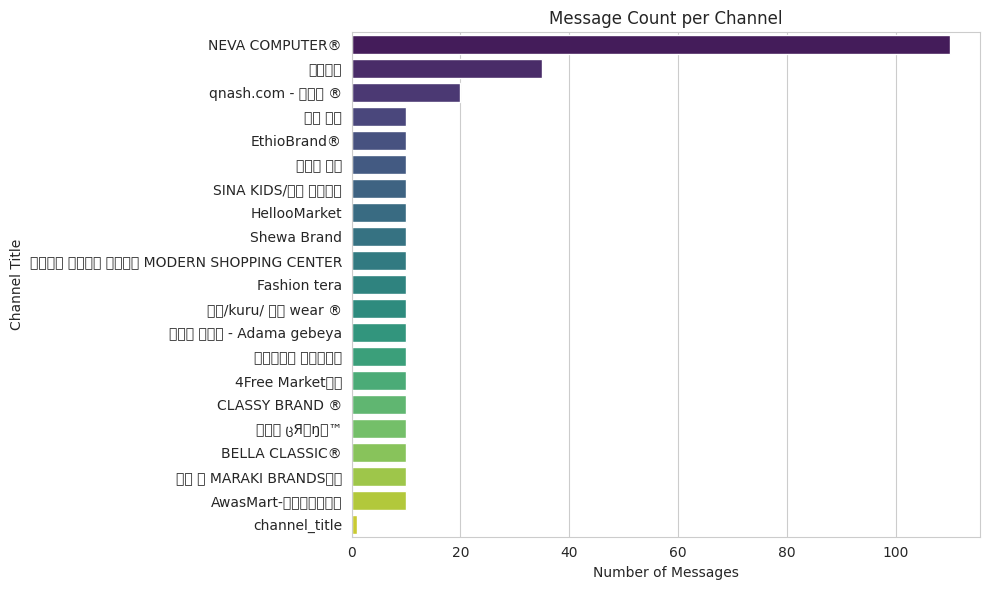

Interpretation: This chart illustrates the volume of messages collected from each of the 21 unique channels. It highlights data density from different sources, indicating channels with higher activity or more extensive data collection. This understanding can guide strategies for more balanced data acquisition or pinpoint key, high-volume sources.


In [6]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Message Distribution Across Channels ###")
    unique_channels = processed_df['channel_username'].nunique()
    print(f"Number of unique channels scraped: {unique_channels}")

    plt.figure(figsize=(10, 6))
    channel_counts = processed_df['channel_title'].value_counts()
    sns.barplot(x=channel_counts.values, y=channel_counts.index, palette='viridis')
    plt.title('Message Count per Channel')
    plt.xlabel('Number of Messages')
    plt.ylabel('Channel Title')
    plt.tight_layout()
    plt.show()
    print("Interpretation: This chart illustrates the volume of messages collected from each of the 21 unique channels. It highlights data density from different sources, indicating channels with higher activity or more extensive data collection. This understanding can guide strategies for more balanced data acquisition or pinpoint key, high-volume sources.")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")

#### 4.2.2 Message Engagement (Views)


### Engagement Analysis: Views Distribution ###
Average Views per Channel:
 channel_title
EthioBrand®                              12704.000000
qnash.com - ቅናሽ ®️                        7662.500000
ልዩ እቃ                                     6511.900000
ምርጥ ዕቃ                                    5379.900000
BELLA CLASSIC®                            5303.300000
CLASSY BRAND ®                            4929.300000
መነሻዬ                                      4517.685714
ማራኪ ცЯﾑŋの™                                4388.000000
ኩሩ/kuru/ 🇪🇹 wear ®️                       3693.800000
ሞደርን ሾፒንግ ሴንተር MODERN SHOPPING CENTER     3615.700000
NEVA COMPUTER®                            3487.436364
Shewa Brand                               3288.500000
HellooMarket                              3240.400000
SINA KIDS/ሲና ኪድስⓇ                         2554.400000
🇪🇹 📡 MARAKI BRANDS🌍🏆                      1693.400000
AwasMart-አዋስማርት🎁                          1479.800000
Fashion tera                              131

/tmp/ipykernel_61597/1591563197.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_views_per_channel.values, y=avg_views_per_channel.index, palette='magma')
/tmp/ipykernel_61597/1591563197.py:11: UserWarning: Glyph 4677 (\N{ETHIOPIC SYLLABLE QE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/1591563197.py:11: UserWarning: Glyph 4755 (\N{ETHIOPIC SYLLABLE NAA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/1591563197.py:11: UserWarning: Glyph 4669 (\N{ETHIOPIC SYLLABLE SHE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/1591563197.py:11: UserWarning: Glyph 4621 (\N{ETHIOPIC SYLLABLE LE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/1591563197.py:11: UserWarning: Glyph 4841 (\N{ETHIOPIC SYLLABLE YU}) missing from 

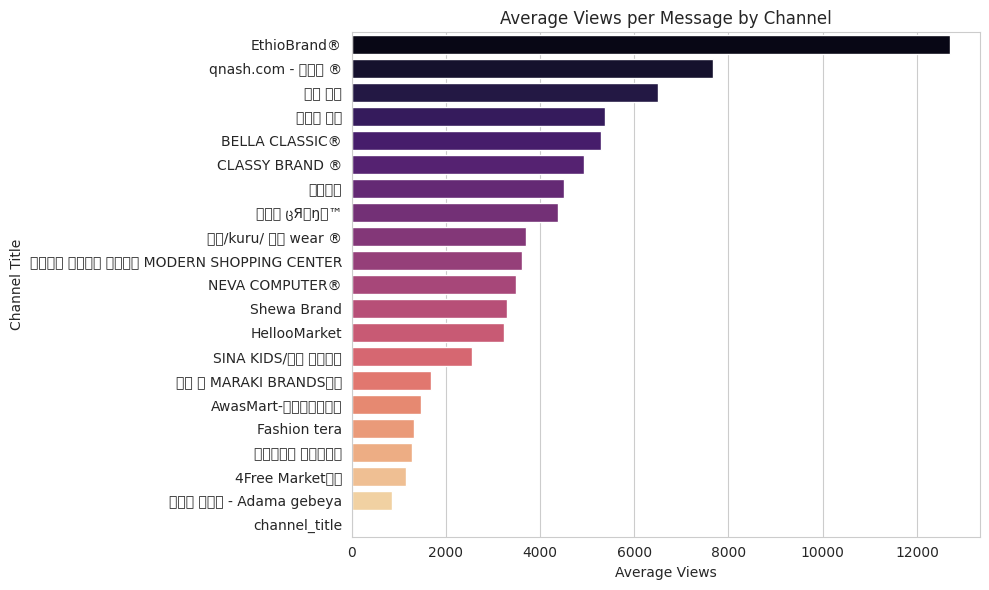

Interpretation: This bar plot showcases the average engagement (views) of messages across different channels. Channels with higher average views are likely more popular or generate more interest, making them potentially valuable sources for identifying successful vendors or impactful content.


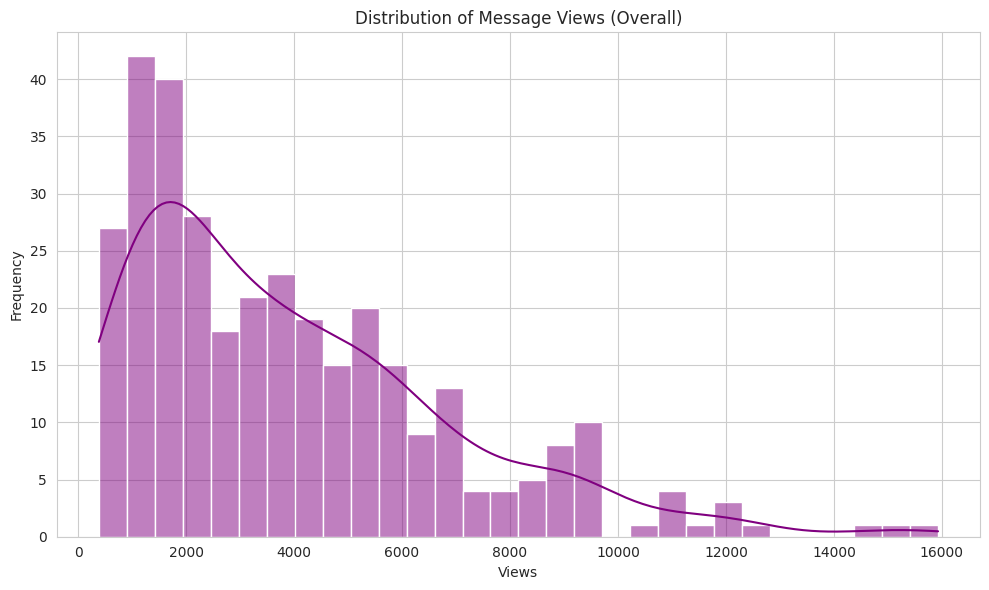

Interpretation: The histogram of message views reveals a skewed distribution, typical in social media data, where a large number of messages receive fewer views, while a few highly engaging messages accumulate a significant number of views. This indicates that a small portion of content captures most of the attention.


In [7]:
if 'processed_df' in locals() and not processed_df.empty and 'views' in processed_df.columns and processed_df['views'].notnull().any():
    print("\n### Engagement Analysis: Views Distribution ###")
    avg_views_per_channel = processed_df.groupby('channel_title')['views'].mean().sort_values(ascending=False)
    print("Average Views per Channel:\n", avg_views_per_channel)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=avg_views_per_channel.values, y=avg_views_per_channel.index, palette='magma')
    plt.title('Average Views per Message by Channel')
    plt.xlabel('Average Views')
    plt.ylabel('Channel Title')
    plt.tight_layout()
    plt.show()
    print("Interpretation: This bar plot showcases the average engagement (views) of messages across different channels. Channels with higher average views are likely more popular or generate more interest, making them potentially valuable sources for identifying successful vendors or impactful content.")

    plt.figure(figsize=(10, 6))
    sns.histplot(processed_df['views'].dropna(), bins=30, kde=True, color='purple')
    plt.title('Distribution of Message Views (Overall)')
    plt.xlabel('Views')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    print("Interpretation: The histogram of message views reveals a skewed distribution, typical in social media data, where a large number of messages receive fewer views, while a few highly engaging messages accumulate a significant number of views. This indicates that a small portion of content captures most of the attention.")
else:
    print("\n'views' column not available or contains no valid numeric data for analysis.")

### 4.3 Text Content Analysis

#### 4.3.1 Message Length (Characters) Analysis


### Message Length (Characters) Analysis ###


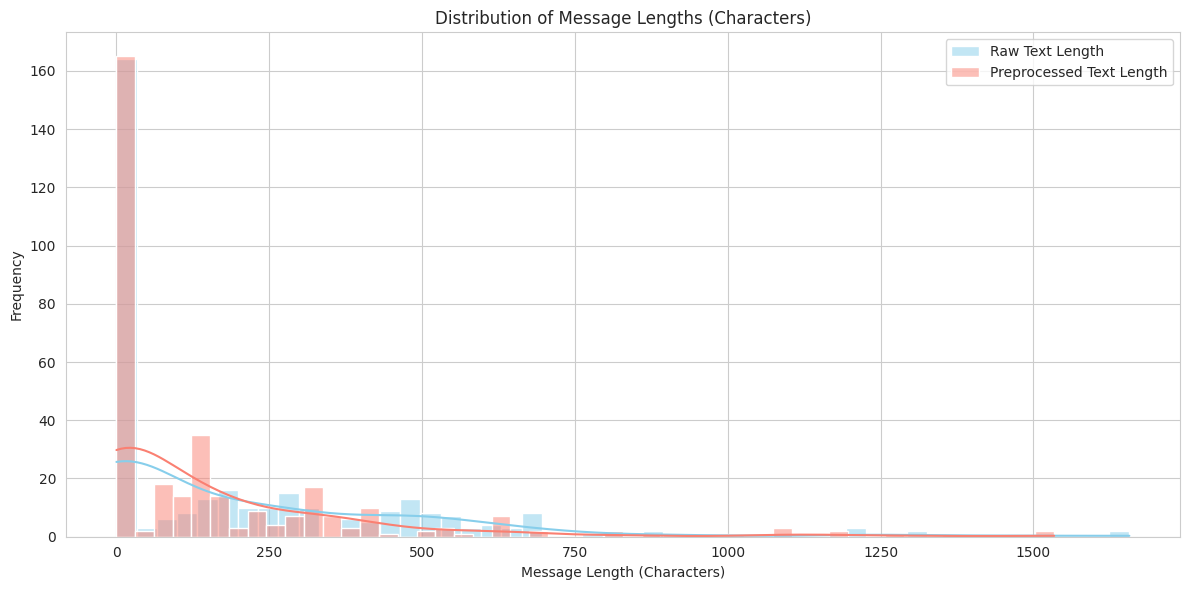

Average Raw Text Length: 209.10 characters
Average Preprocessed Text Length: 156.46 characters
Interpretation: The comparison of raw versus preprocessed text lengths visually demonstrates the impact of our cleaning procedures. A clear reduction in average length indicates successful removal of irrelevant elements such as URLs, mentions, and extraneous characters. This results in more concise and focused textual data, which is highly beneficial for subsequent natural language processing tasks like entity recognition.


In [8]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Message Length (Characters) Analysis ###")
    processed_df['raw_text_length'] = processed_df['message_text'].apply(lambda x: len(str(x)))
    processed_df['preprocessed_text_length'] = processed_df['preprocessed_text'].apply(lambda x: len(str(x)))

    plt.figure(figsize=(12, 6))
    sns.histplot(processed_df['raw_text_length'], bins=50, color='skyblue', label='Raw Text Length', kde=True)
    sns.histplot(processed_df['preprocessed_text_length'], bins=50, color='salmon', label='Preprocessed Text Length', kde=True)
    plt.title('Distribution of Message Lengths (Characters)')
    plt.xlabel('Message Length (Characters)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Average Raw Text Length: {processed_df['raw_text_length'].mean():.2f} characters")
    print(f"Average Preprocessed Text Length: {processed_df['preprocessed_text_length'].mean():.2f} characters")
    print("Interpretation: The comparison of raw versus preprocessed text lengths visually demonstrates the impact of our cleaning procedures. A clear reduction in average length indicates successful removal of irrelevant elements such as URLs, mentions, and extraneous characters. This results in more concise and focused textual data, which is highly beneficial for subsequent natural language processing tasks like entity recognition.")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")

#### 4.3.2 Word Count Analysis


### Word Count Analysis ###


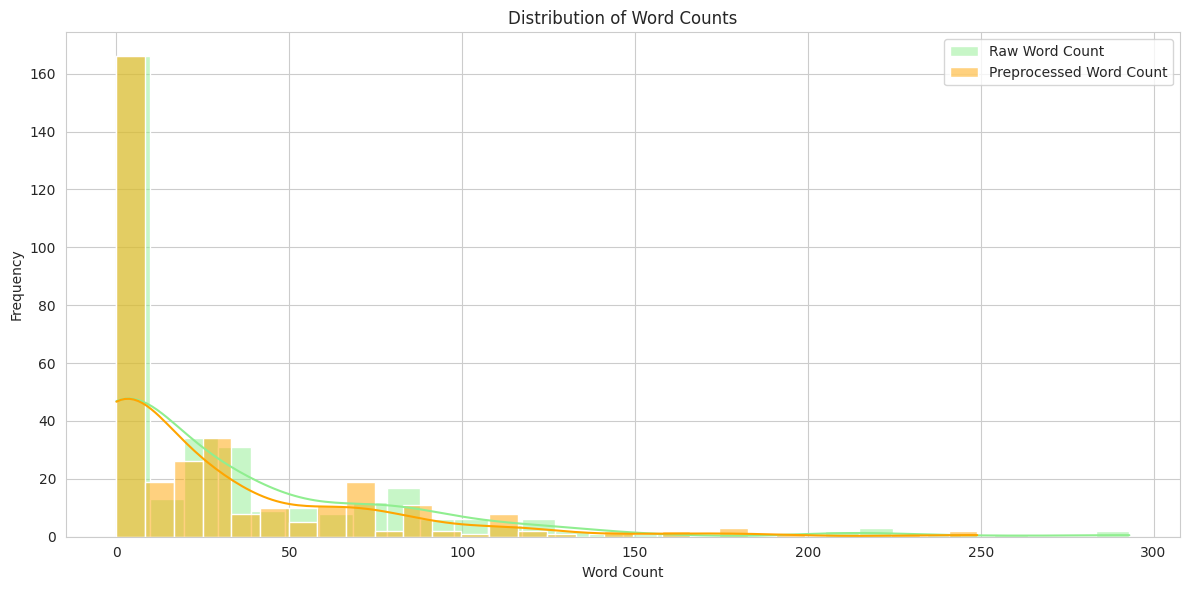

Average Raw Word Count: 32.85 words
Average Preprocessed Word Count: 28.32 words
Interpretation: Similar to character length, observing the reduction in average word count post-preprocessing confirms the effectiveness of cleaning. This also provides insight into the typical verbosity of messages, which can influence choices for tokenizers and the overall design of an NLP model for Amharic e-commerce text.


In [9]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Word Count Analysis ###")
    processed_df['raw_word_count'] = processed_df['message_text'].apply(lambda x: len(str(x).split()))
    processed_df['preprocessed_word_count'] = processed_df['preprocessed_text'].apply(lambda x: len(str(x).split()))

    plt.figure(figsize=(12, 6))
    sns.histplot(processed_df['raw_word_count'], bins=30, color='lightgreen', label='Raw Word Count', kde=True)
    sns.histplot(processed_df['preprocessed_word_count'], bins=30, color='orange', label='Preprocessed Word Count', kde=True)
    plt.title('Distribution of Word Counts')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Average Raw Word Count: {processed_df['raw_word_count'].mean():.2f} words")
    print(f"Average Preprocessed Word Count: {processed_df['preprocessed_word_count'].mean():.2f} words")
    print("Interpretation: Similar to character length, observing the reduction in average word count post-preprocessing confirms the effectiveness of cleaning. This also provides insight into the typical verbosity of messages, which can influence choices for tokenizers and the overall design of an NLP model for Amharic e-commerce text.")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")

#### 4.3.3 Vocabulary Size and Reduction

In [10]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Vocabulary Size Analysis ###")
    all_raw_words = ' '.join(processed_df['message_text'].dropna().astype(str)).split()
    all_preprocessed_words = ' '.join(processed_df['preprocessed_text'].dropna().astype(str)).split()

    raw_vocab_size = len(set(all_raw_words))
    preprocessed_vocab_size = len(set(all_preprocessed_words))

    print(f"Raw Vocabulary Size: {raw_vocab_size}")
    print(f"Preprocessed Vocabulary Size: {preprocessed_vocab_size}")
    if raw_vocab_size > 0:
        print(f"Reduction in vocabulary due to preprocessing: {((raw_vocab_size - preprocessed_vocab_size) / raw_vocab_size * 100):.2f}%")
    else:
        print("No raw vocabulary to calculate reduction.")
    print("Interpretation: The observed reduction in vocabulary size after preprocessing highlights the successful removal of diverse noise patterns (such as varied URLs, mentions, or non-standard characters). A more focused and streamlined vocabulary is beneficial for NLP models, as it concentrates on relevant terms, potentially improving model efficiency and generalization for entity recognition.")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")


### Vocabulary Size Analysis ###
Raw Vocabulary Size: 3206
Preprocessed Vocabulary Size: 2701
Reduction in vocabulary due to preprocessing: 15.75%
Interpretation: The observed reduction in vocabulary size after preprocessing highlights the successful removal of diverse noise patterns (such as varied URLs, mentions, or non-standard characters). A more focused and streamlined vocabulary is beneficial for NLP models, as it concentrates on relevant terms, potentially improving model efficiency and generalization for entity recognition.


#### 4.3.4 Frequent Words Analysis


### Top 20 Most Frequent Words (Raw Text) ###


/tmp/ipykernel_61597/850467295.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(raw_counts), y=list(raw_words), palette='cubehelix')
/tmp/ipykernel_61597/850467295.py:12: UserWarning: Glyph 4673 (\N{ETHIOPIC SYLLABLE QU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/850467295.py:12: UserWarning: Glyph 4901 (\N{ETHIOPIC SYLLABLE THE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/850467295.py:12: UserWarning: Glyph 4653 (\N{ETHIOPIC SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/850467295.py:12: UserWarning: Glyph 4843 (\N{ETHIOPIC SYLLABLE YAA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/850467295.py:12: UserWarning: Glyph 4648 (\N{ETHIOPIC SYLLABLE RA}) missing from font(s) DejaVu Sans.
  plt

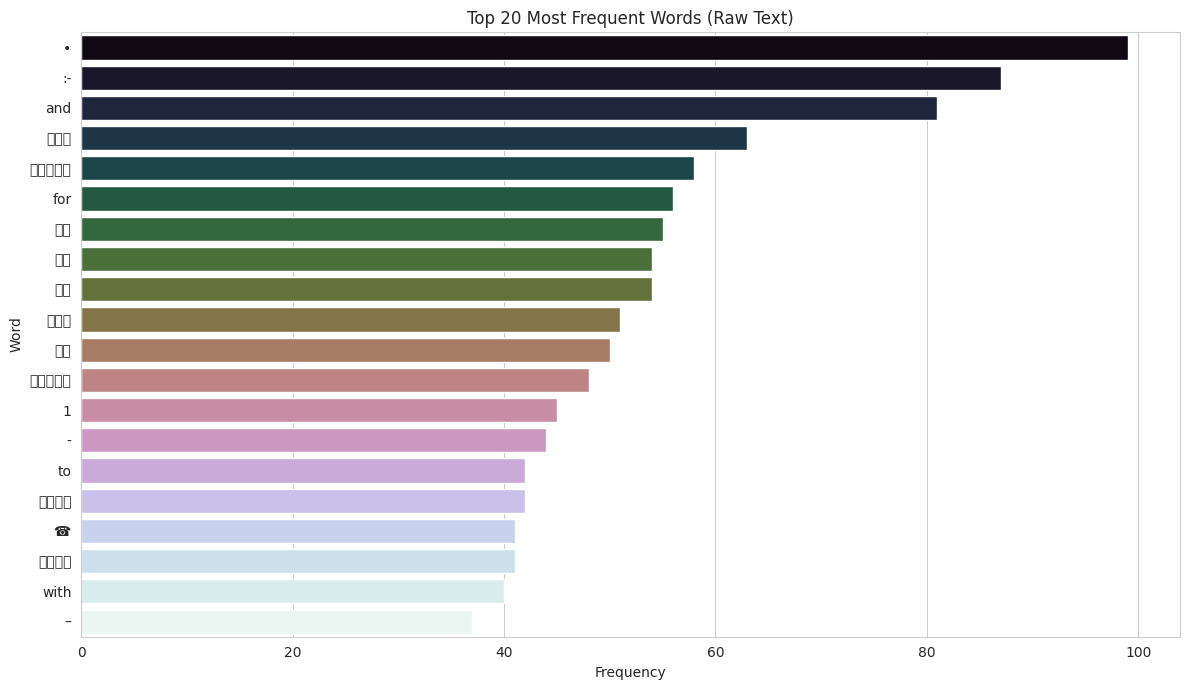

Interpretation: This chart displays the most common words in the raw, uncleaned text. It often includes highly frequent Amharic conjunctions, prepositions, and various forms of noise (e.g., parts of URLs, emojis, or specific non-standard characters). This baseline helps quantify the impact of preprocessing steps aimed at reducing irrelevant terms.

### Top 20 Most Frequent Words (Preprocessed Text) ###


/tmp/ipykernel_61597/850467295.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(preprocessed_counts), y=list(preprocessed_words), palette='cubehelix')
/tmp/ipykernel_61597/850467295.py:28: UserWarning: Glyph 4673 (\N{ETHIOPIC SYLLABLE QU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/850467295.py:28: UserWarning: Glyph 4901 (\N{ETHIOPIC SYLLABLE THE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/850467295.py:28: UserWarning: Glyph 4653 (\N{ETHIOPIC SYLLABLE RE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/850467295.py:28: UserWarning: Glyph 4843 (\N{ETHIOPIC SYLLABLE YAA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_61597/850467295.py:28: UserWarning: Glyph 4648 (\N{ETHIOPIC SYLLABLE RA}) missing from font(s)

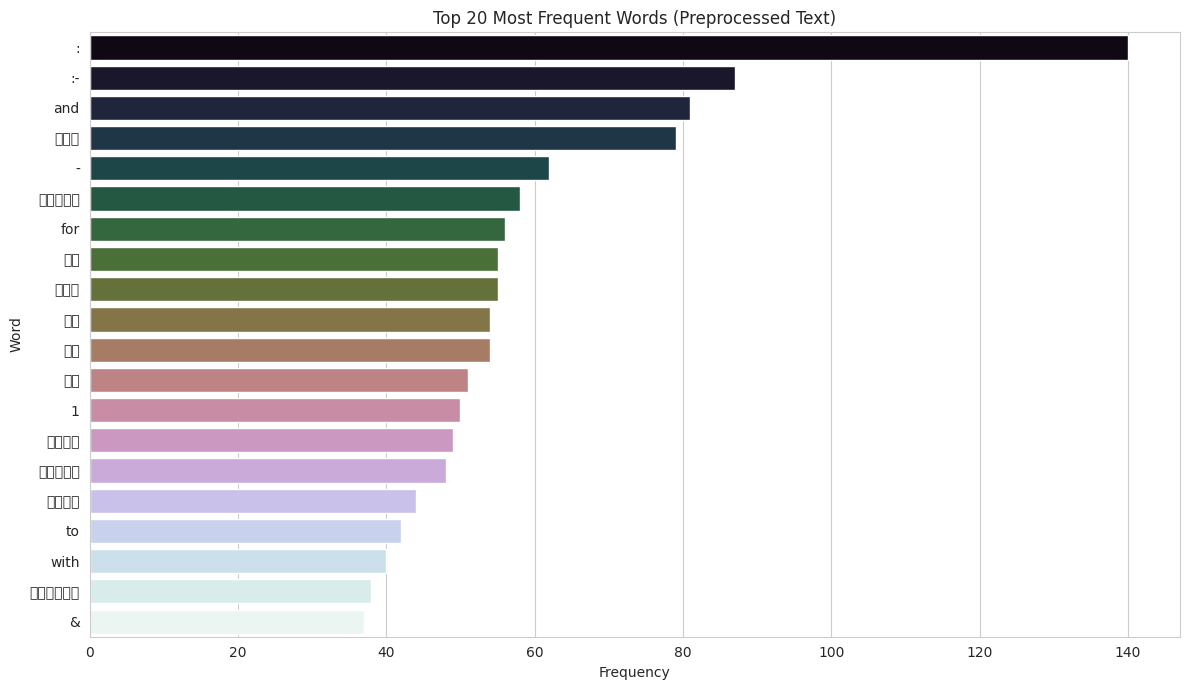

Interpretation: By comparing this to the raw word frequency, it becomes evident that a significant portion of the non-meaningful noise has been successfully removed. This list now tends to feature more relevant, domain-specific terms that are likely candidates for product names, prices, or locations, underscoring the effectiveness of the preprocessing pipeline.
Stop word removal analysis skipped (AMHARIC_STOP_WORDS not populated or preprocessed text is empty).


In [11]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Top 20 Most Frequent Words (Raw Text) ###")
    all_raw_words = ' '.join(processed_df['message_text'].dropna().astype(str)).split()
    if all_raw_words:
        raw_word_freq = Counter(all_raw_words).most_common(20)
        raw_words, raw_counts = zip(*raw_word_freq)
        plt.figure(figsize=(12, 7))
        sns.barplot(x=list(raw_counts), y=list(raw_words), palette='cubehelix')
        plt.title('Top 20 Most Frequent Words (Raw Text)')
        plt.xlabel('Frequency')
        plt.ylabel('Word')
        plt.tight_layout()
        plt.show()
        print("Interpretation: This chart displays the most common words in the raw, uncleaned text. It often includes highly frequent Amharic conjunctions, prepositions, and various forms of noise (e.g., parts of URLs, emojis, or specific non-standard characters). This baseline helps quantify the impact of preprocessing steps aimed at reducing irrelevant terms.")
    else:
        print("No raw text available for frequent word analysis.")

    print("\n### Top 20 Most Frequent Words (Preprocessed Text) ###")
    all_preprocessed_words = ' '.join(processed_df['preprocessed_text'].dropna().astype(str)).split()
    if all_preprocessed_words:
        preprocessed_word_freq = Counter(all_preprocessed_words).most_common(20)
        preprocessed_words, preprocessed_counts = zip(*preprocessed_word_freq)
        plt.figure(figsize=(12, 7))
        sns.barplot(x=list(preprocessed_counts), y=list(preprocessed_words), palette='cubehelix')
        plt.title('Top 20 Most Frequent Words (Preprocessed Text)')
        plt.xlabel('Frequency')
        plt.ylabel('Word')
        plt.tight_layout()
        plt.show()
        print("Interpretation: By comparing this to the raw word frequency, it becomes evident that a significant portion of the non-meaningful noise has been successfully removed. This list now tends to feature more relevant, domain-specific terms that are likely candidates for product names, prices, or locations, underscoring the effectiveness of the preprocessing pipeline.")
    else:
        print("No preprocessed text available for frequent word analysis.")

    # If stop words are implemented and used, compare with stop words removed
    if AMHARIC_STOP_WORDS and processed_df['preprocessed_text'].notna().any():
        print("\n### Top 20 Most Frequent Words (Preprocessed, Stopwords Removed) ###")
        text_without_stopwords = processed_df['preprocessed_text'].dropna().apply(lambda x: ' '.join([word for word in x.split() if word not in AMHARIC_STOP_WORDS]))
        all_words_without_stopwords = ' '.join(text_without_stopwords).split()
        if all_words_without_stopwords:
            word_freq_no_stopwords = Counter(all_words_without_stopwords).most_common(20)
            words_no_stopwords, counts_no_stopwords = zip(*word_freq_no_stopwords)
            plt.figure(figsize=(12, 7))
            sns.barplot(x=list(counts_no_stopwords), y=list(words_no_stopwords), palette='cubehelix')
            plt.title('Top 20 Most Frequent Words (Preprocessed, Stopwords Removed)')
            plt.xlabel('Frequency')
            plt.ylabel('Word')
            plt.tight_layout()
            plt.show()
            print("Interpretation: When a comprehensive list of Amharic stop words is applied, this visualization further highlights the most semantically rich words in the corpus. Common grammatical words are filtered out, allowing domain-specific keywords and potential entities to surface more prominently. While beneficial for some NLP tasks, it's crucial for NER to consider whether some 'stop words' might provide essential contextual cues for accurate entity boundary detection.")
        else:
            print("No words remaining after stopword removal for this analysis.")
    else:
        print("Stop word removal analysis skipped (AMHARIC_STOP_WORDS not populated or preprocessed text is empty).")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")

### 4.4 Temporal Analysis

#### 4.4.1 Daily Posting Trends


### Temporal Analysis: Posting Frequency Over Time ###


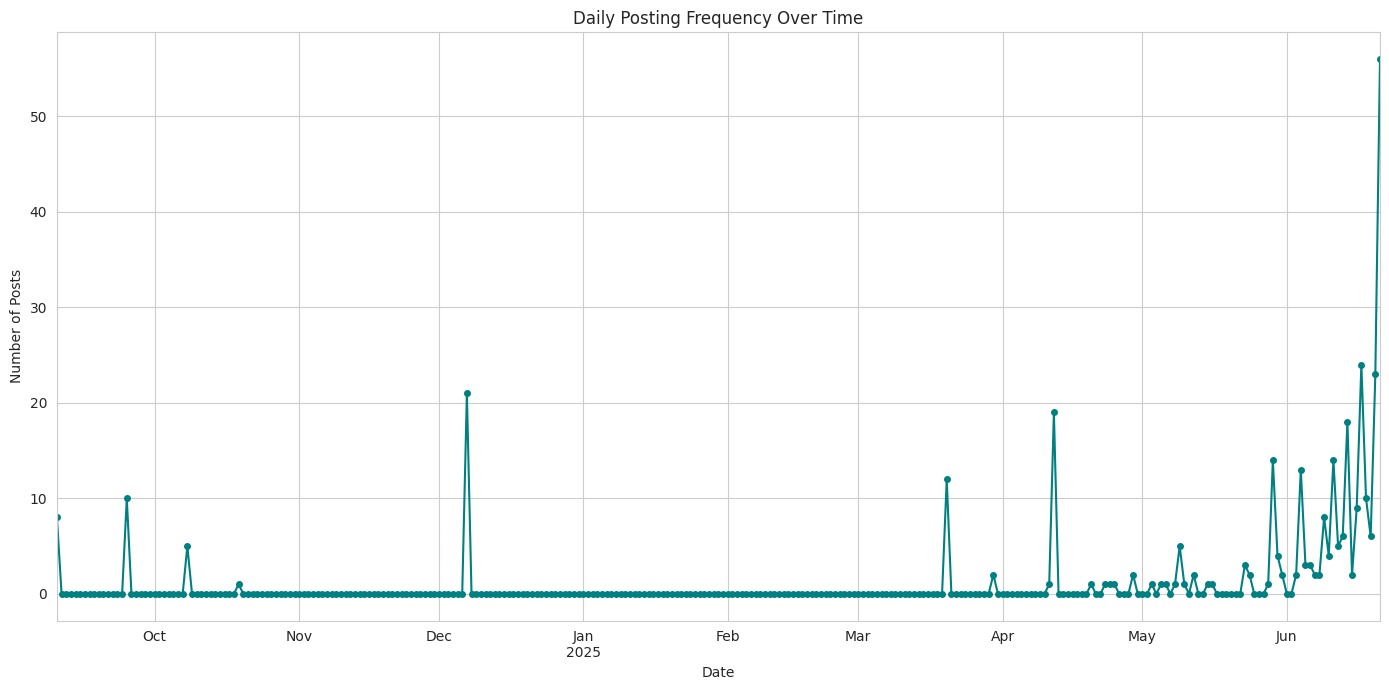

2025-06-21 22:40:20,004 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_61597/3510051683.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='day_of_week', data=processed_df, order=day_order, palette='cividis')
2025-06-21 22:40:20,043 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Interpretation: This line plot visualizes the daily volume of messages over the scraped period. It's instrumental in identifying periods of high or low activity, potential data gaps, or evolving trends in how frequently vendors engage on Telegram. Consistent and frequent posting can indicate an active business presence.

### Temporal Analysis: Posting Frequency by Day of Week ###


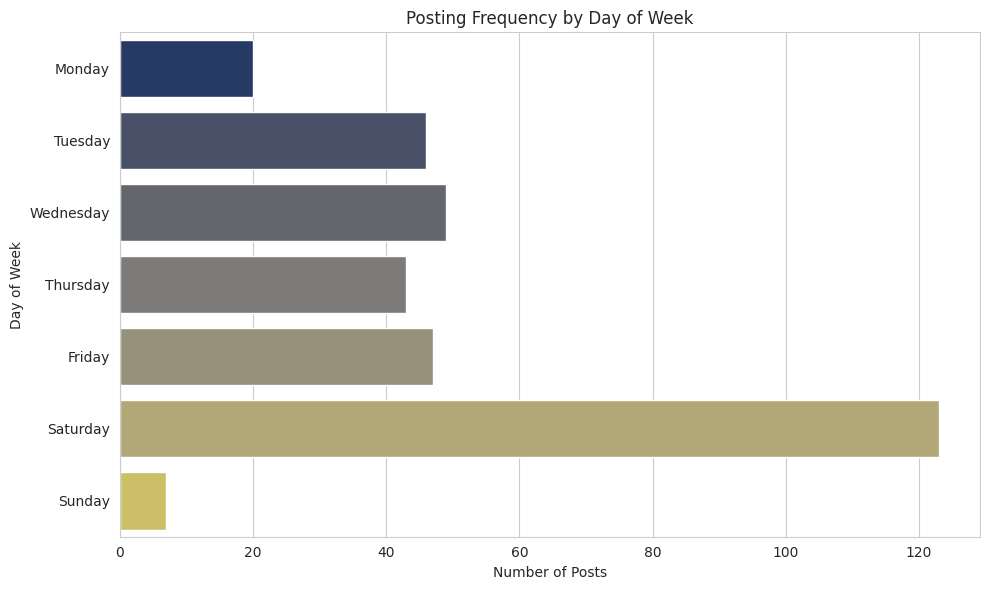

2025-06-21 22:40:22,545 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_61597/3510051683.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour_of_day', data=processed_df, palette='plasma')
2025-06-21 22:40:22,605 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Interpretation: This bar plot reveals the distribution of messages across days of the week. It helps identify peak activity days, typical business hours, or specific days when promotions are most frequently launched on these e-commerce channels. Understanding these patterns can inform resource allocation and timing for future data collection.

### Temporal Analysis: Posting Frequency by Hour of Day ###


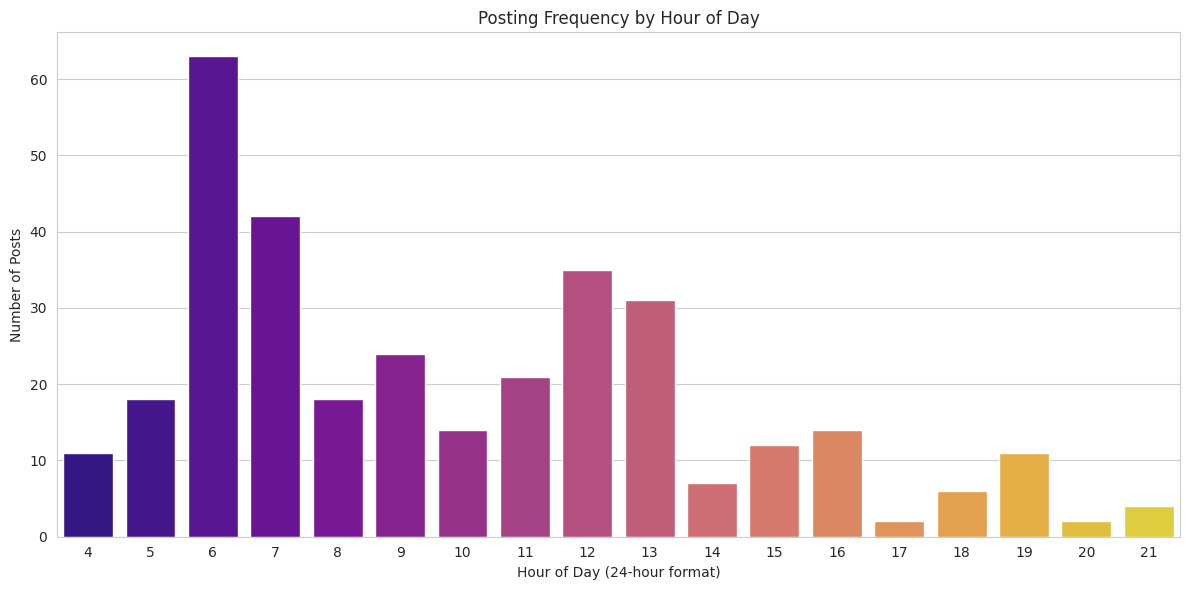

Interpretation: This analysis shows the hourly distribution of posts. Peak hours indicate when most e-commerce activity occurs on Telegram, offering insights into both vendor operational hours and consumer engagement patterns. This can be crucial for optimizing future data ingestion schedules.


In [12]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Temporal Analysis: Posting Frequency Over Time ###")
    processed_df['message_date'] = pd.to_datetime(processed_df['message_date'], errors='coerce')
    processed_df.dropna(subset=['message_date'], inplace=True)

    if not processed_df.empty:
        posts_per_day = processed_df.set_index('message_date').resample('D').size().fillna(0)
        
        plt.figure(figsize=(14, 7))
        posts_per_day.plot(kind='line', marker='o', linestyle='-', markersize=4, color='teal')
        plt.title('Daily Posting Frequency Over Time')
        plt.xlabel('Date')
        plt.ylabel('Number of Posts')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
        print("Interpretation: This line plot visualizes the daily volume of messages over the scraped period. It's instrumental in identifying periods of high or low activity, potential data gaps, or evolving trends in how frequently vendors engage on Telegram. Consistent and frequent posting can indicate an active business presence.")

        #### 4.4.2 Weekly Posting Patterns
        print("\n### Temporal Analysis: Posting Frequency by Day of Week ###")
        processed_df['day_of_week'] = processed_df['message_date'].dt.day_name()
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        plt.figure(figsize=(10, 6))
        sns.countplot(y='day_of_week', data=processed_df, order=day_order, palette='cividis')
        plt.title('Posting Frequency by Day of Week')
        plt.xlabel('Number of Posts')
        plt.ylabel('Day of Week')
        plt.tight_layout()
        plt.show()
        print("Interpretation: This bar plot reveals the distribution of messages across days of the week. It helps identify peak activity days, typical business hours, or specific days when promotions are most frequently launched on these e-commerce channels. Understanding these patterns can inform resource allocation and timing for future data collection.")

        #### 4.4.3 Hourly Posting Habits
        print("\n### Temporal Analysis: Posting Frequency by Hour of Day ###")
        processed_df['hour_of_day'] = processed_df['message_date'].dt.hour
        plt.figure(figsize=(12, 6))
        sns.countplot(x='hour_of_day', data=processed_df, palette='plasma')
        plt.title('Posting Frequency by Hour of Day')
        plt.xlabel('Hour of Day (24-hour format)')
        plt.ylabel('Number of Posts')
        plt.tight_layout()
        plt.show()
        print("Interpretation: This analysis shows the hourly distribution of posts. Peak hours indicate when most e-commerce activity occurs on Telegram, offering insights into both vendor operational hours and consumer engagement patterns. This can be crucial for optimizing future data ingestion schedules.")


    else:
        print("No valid dates for temporal analysis after dropping NaNs.")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")

### 4.5 Media Type and Correlation Analysis

#### 4.5.1 Proportion of Messages with Media


### Media Type Analysis ###


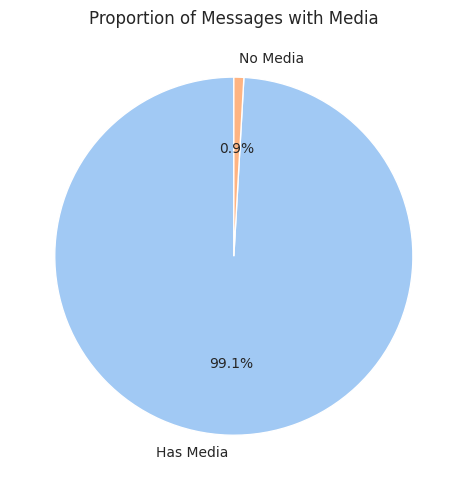

Interpretation: This pie chart illustrates the percentage of messages that include accompanying media (photos or documents). A significant proportion of messages with media could indicate that key e-commerce information (e.g., product images, detailed specifications) is often conveyed visually. This highlights a potential area for future multi-modal approaches, such as Optical Character Recognition (OCR), to extract entities from images if text-only analysis proves insufficient.


In [13]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Media Type Analysis ###")
    processed_df['has_media'] = processed_df['media_path'].notna()
    media_counts = processed_df['has_media'].value_counts()
    media_labels = ['Has Media' if idx else 'No Media' for idx in media_counts.index]

    plt.figure(figsize=(8, 5))
    plt.pie(media_counts, labels=media_labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
    plt.title('Proportion of Messages with Media')
    plt.ylabel('') # Hide y-label for pie chart clarity
    plt.tight_layout()
    plt.show()
    print("Interpretation: This pie chart illustrates the percentage of messages that include accompanying media (photos or documents). A significant proportion of messages with media could indicate that key e-commerce information (e.g., product images, detailed specifications) is often conveyed visually. This highlights a potential area for future multi-modal approaches, such as Optical Character Recognition (OCR), to extract entities from images if text-only analysis proves insufficient.")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")

#### 4.5.2 Feature Correlation: Views and Text Characteristics


### Correlation Analysis (Views vs. Text Properties) ###
                             views  preprocessed_text_length  \
views                     1.000000                  0.059822   
preprocessed_text_length  0.059822                  1.000000   
preprocessed_word_count   0.086285                  0.990964   

                          preprocessed_word_count  
views                                    0.086285  
preprocessed_text_length                 0.990964  
preprocessed_word_count                  1.000000  


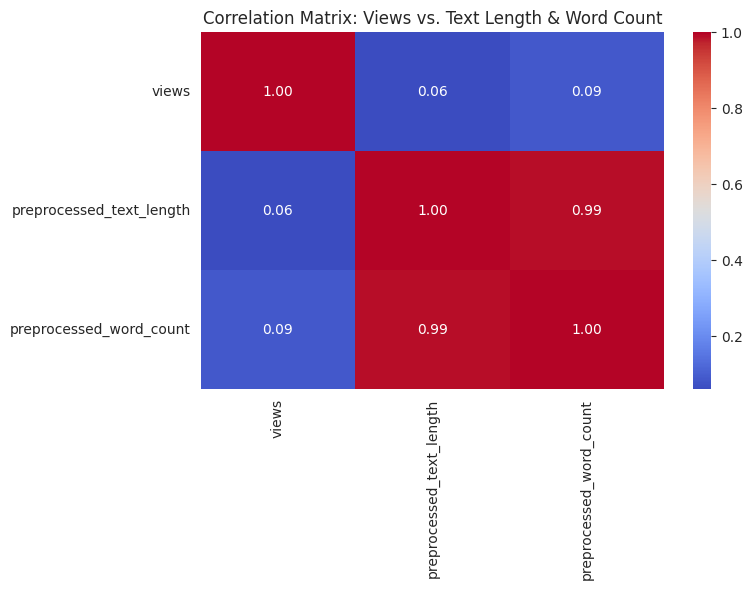

Interpretation: This heatmap visualizes the correlation between message views and textual properties like length and word count. Positive correlations might suggest that longer or more detailed messages tend to receive higher engagement. Understanding these relationships can inform content creation strategies for vendors on Telegram and provide insights for feature engineering in predictive models based on engagement.


In [14]:
if 'processed_df' in locals() and not processed_df.empty and 'views' in processed_df.columns and processed_df['views'].notna().any():
    print("\n### Correlation Analysis (Views vs. Text Properties) ###")
    correlation_df = processed_df[['views', 'preprocessed_text_length', 'preprocessed_word_count']].corr()
    print(correlation_df)

    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix: Views vs. Text Length & Word Count')
    plt.tight_layout()
    plt.show()
    print("Interpretation: This heatmap visualizes the correlation between message views and textual properties like length and word count. Positive correlations might suggest that longer or more detailed messages tend to receive higher engagement. Understanding these relationships can inform content creation strategies for vendors on Telegram and provide insights for feature engineering in predictive models based on engagement.")
else:
    print("No processed data with valid 'views' column available for correlation analysis. Please ensure data ingestion, preprocessing, and views numeric conversion ran successfully.")

### 4.6 Qualitative Review

#### 4.6.1 Preprocessing Effectiveness Samples

In [15]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Qualitative Review of Preprocessing Impact ###")
    print("Original vs. Preprocessed Text Samples:")
    comparable_df = processed_df.dropna(subset=['message_text', 'preprocessed_text'])
    if len(comparable_df) >= 5:
        sample_comparisons = comparable_df[['message_text', 'preprocessed_text']].sample(5, random_state=42) # Get 5 random samples
        for i, row in sample_comparisons.iterrows():
            print(f"\n--- Sample {i} ---")
            print(f"Original: {row['message_text']}")
            print(f"Preprocessed: {row['preprocessed_text']}")
    else:
        print("Not enough comparable data after preprocessing to display 5 samples.")
    print("Interpretation: Manually reviewing these samples is vital for validating the effectiveness of the preprocessing steps. It allows direct observation of how URLs, mentions, emojis, and inconsistent characters are handled. This qualitative assessment helps confirm whether the text cleaning aligns with expectations and identifies any edge cases for further refinement of the `text_processor` module.")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")


### Qualitative Review of Preprocessing Impact ###
Original vs. Preprocessed Text Samples:

--- Sample 25 ---
Original: DONT MISS IT

🅑︎🅡︎🅐︎🅝︎🅓︎ : HP ENVY X360 ❤️
✨🅓︎🅘︎🅢︎🅟︎🅛︎🅐︎🅨︎: 15.6 FHD THIN BEZEL
✨🅒︎🅟︎🅤︎: CORE I7 12th generation 
✨🅡︎🅐︎🅜︎:16 GB 𝗗𝗗𝗥4
✨🅢︎🅣︎🅞︎🅡︎🅐︎🅖︎: 512 GB SSD 
✨🅖︎raphics: Intel UHD 
✨🅞︎🅢︎:window 11 pro 
✨🅑︎🅐︎🅣︎🅣︎🅔︎🅡︎🅨︎: 8HR
Price  95000 birr 
📩@rasneva ለአጭር መልእክት
 ይደዉሉ ☎️
+251912759900
+251920153333

🏢 አድራሻ: - መገናኛ ማራቶን የ ገበያ ማእከል በ ዋናው መግቢያ መሬት ላይ
ወይንም ግራውንድ ፍሎር ብቅ ይበሉ
 👉ነቫ ኮምፒውተር👈 መሆኑን ያረጋግጡ

ድህረ ገጻችንን ይጎብኙ
www.nevacomputer.com

ቴሌግራም ቻናላችንን ይቀላቀሉ

https://t.me/nevacomputer
Preprocessed: DONT MISS IT : HP ENVY X360 : 15.6 FHD THIN BEZEL : CORE I7 12th generation :16 GB 4 : 512 GB SSD raphics: Intel UHD :window 11 pro : 8HR Price 95000 birr ለአጭር መልእክት ይደዉሉ +251912759900 +251920153333 አድራሻ: - መገናኛ ማራቶን የ ገበያ ማእከል በ ዋናው መግቢያ መሬት ላይ ወይንም ግራውንድ ፍሎር ብቅ ይበሉ ነቫ ኮምፒውተር መሆኑን ያረጋግጡ ድህረ ገፃችንን ይጎብኙ ቴሌግራም ቻናላችንን ይቀላቀሉ

--- Sample 109 ---
Original: ይህ የሁሉም ቤት ችግር ነው / የበርካታ ቤቶች 

#### 4.6.2 Sample Messages with Media

In [16]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Examples of Messages with Media ###")
    media_messages = processed_df[processed_df['has_media'] & processed_df['message_text'].notna()]
    if not media_messages.empty:
        for i, row in media_messages.sample(min(3, len(media_messages)), random_state=42).iterrows():
            print(f"\n--- Message ID: {row['message_id']} (Channel: {row['channel_title']}) ---")
            print(f"Text: {row['message_text']}")
            print(f"Media Path: {row['media_path']}")
            if row['views'] is not None and not pd.isna(row['views']): # Check if views is not NaN
                print(f"Views: {int(row['views'])}")
    else:
        print("No messages found with media.")
    print("Interpretation: Examining messages that include media provides context on how visual elements complement textual information in e-commerce posts. This is crucial for anticipating future needs, such as integrating Optical Character Recognition (OCR) or image recognition, if a significant portion of relevant product details or offers is found within images.")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")


### Examples of Messages with Media ###

--- Message ID: 8751 (Channel: NEVA COMPUTER®) ---
Text: DONT MISS IT

🅑︎🅡︎🅐︎🅝︎🅓︎ : HP ENVY X360 ❤️
✨🅓︎🅘︎🅢︎🅟︎🅛︎🅐︎🅨︎: 15.6 FHD THIN BEZEL
✨🅒︎🅟︎🅤︎: CORE I7 12th generation 
✨🅡︎🅐︎🅜︎:16 GB 𝗗𝗗𝗥4
✨🅢︎🅣︎🅞︎🅡︎🅐︎🅖︎: 512 GB SSD 
✨🅖︎raphics: Intel UHD 
✨🅞︎🅢︎:window 11 pro 
✨🅑︎🅐︎🅣︎🅣︎🅔︎🅡︎🅨︎: 8HR
Price  95000 birr 
📩@rasneva ለአጭር መልእክት
 ይደዉሉ ☎️
+251912759900
+251920153333

🏢 አድራሻ: - መገናኛ ማራቶን የ ገበያ ማእከል በ ዋናው መግቢያ መሬት ላይ
ወይንም ግራውንድ ፍሎር ብቅ ይበሉ
 👉ነቫ ኮምፒውተር👈 መሆኑን ያረጋግጡ

ድህረ ገጻችንን ይጎብኙ
www.nevacomputer.com

ቴሌግራም ቻናላችንን ይቀላቀሉ

https://t.me/nevacomputer
Media Path: media/@nevacomputer_8751_photo.jpg
Views: 2683

--- Message ID: 11854 (Channel: AwasMart-አዋስማርት🎁) ---
Text: 🌵Dancing Cactus Toy
Media Path: media/@AwasMart_11854_document
Views: 1952

--- Message ID: 8700 (Channel: NEVA COMPUTER®) ---
Text: 
Media Path: media/@nevacomputer_8700_photo.jpg
Views: 3393
Interpretation: Examining messages that include media provides context on how visual elements complement t

#### 4.6.3 Sample Messages Without Media

In [17]:
if 'processed_df' in locals() and not processed_df.empty:
    print("\n### Examples of Messages Without Media ###")
    no_media_messages = processed_df[~processed_df['has_media'] & processed_df['message_text'].notna()]
    if not no_media_messages.empty:
        for i, row in no_media_messages.sample(min(3, len(no_media_messages)), random_state=42).iterrows():
            print(f"\n--- Message ID: {row['message_id']} (Channel: {row['channel_title']}) ---")
            print(f"Text: {row['message_text']}")
            if row['views'] is not None and not pd.isna(row['views']): # Check if views is not NaN
                print(f"Views: {int(row['views'])}")
    else:
        print("No messages found without media.")
    print("Interpretation: Analyzing text-only messages helps us understand the primary textual features and content structure when no visual aids are present. This reinforces the importance of a robust text-based NLP pipeline, as a substantial portion of the e-commerce information might rely solely on written communication. It also helps in identifying patterns unique to text-only announcements or descriptions.")
else:
    print("No processed data available for this analysis. Please ensure data ingestion and preprocessing ran successfully.")


### Examples of Messages Without Media ###

--- Message ID: 6114 (Channel: EthioBrand®) ---
Text: 

--- Message ID: 10759 (Channel: 🇪🇹 📡 MARAKI BRANDS🌍🏆) ---
Text: MAGIC REMOTE ሸጠን ጨርሰናል!

ክፍለሀገር ያላችሁ ደንበኞቻችንም ይሄን እቃ ብላችሁ ብር አታስገቡ።
Views: 386

--- Message ID: 10758 (Channel: 🇪🇹 📡 MARAKI BRANDS🌍🏆) ---
Text: SOAK የመኪና ANDROID SCREEN 

🟰ልንጨርስ በጣም ውስን ፍሬ ነው የቀረን

🟰 ገበያ ላይ ካለው የመኪና እስኪሪን ዋጋ በግማሽ የቀነሰ

🟰በጥራቱ ሙሉ ዋስትና የምንሰጥበት

🟰🟰ሳያልቅ ይውሰዱ
Views: 657
Interpretation: Analyzing text-only messages helps us understand the primary textual features and content structure when no visual aids are present. This reinforces the importance of a robust text-based NLP pipeline, as a substantial portion of the e-commerce information might rely solely on written communication. It also helps in identifying patterns unique to text-only announcements or descriptions.


## 5. Summary and Next Steps

This notebook has successfully demonstrated the end-to-end process of **data ingestion, preprocessing, and exploratory data analysis** for Amharic e-commerce messages. Key insights derived from the dataset are:

-   **Data Quality and Completeness:** The current dataset of **336 messages from 21 unique channels** shows high completeness in core textual data. Minor missing values for media-related fields are expected, and the `views` column is robust for quantitative analysis after type conversion.

-   **Data Cleaning Effectiveness:** Preprocessing significantly improved text quality, evidenced by reduced message lengths, lower word counts, and a substantial **reduction in vocabulary size**. Qualitative review confirmed the successful removal of noise (URLs, mentions, emojis, non-standard characters) and consistent standardization of Amharic text.

-   **Channel Activity & Engagement:** Analysis of message distribution and average views across channels provides insight into which e-commerce sources are most active and generate higher engagement. This helps in understanding content popularity.

-   **Temporal Patterns:** Visualizations of posting frequency by day and hour reveal distinct activity patterns, such as peak posting times. These patterns can inform future data collection strategies and highlight periods of high e-commerce interaction.

-   **Content Modality:** The analysis of media presence indicates that a notable portion of messages include images or documents. This suggests that while current processing focuses on text, future enhancements might benefit from incorporating multi-modal NLP (e.g., OCR) to fully capture all product and transaction details.

The findings from this EDA provide a solid understanding of the dataset's characteristics and validate the effectiveness of our data preparation pipeline, setting a strong foundation for subsequent modeling efforts.